In [2]:
import graph_tool.all as gt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/opt/homebrew/Cellar/graph-tool/2.97_1/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:1553: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [3]:
G_Wiki = gt.load_graph("data/G_wiki.gt") 

***
## Descriptives

In [4]:
Max_edges = (G_Wiki.num_vertices()*G_Wiki.num_vertices())-G_Wiki.num_vertices()
Density = G_Wiki.num_edges()/Max_edges

dist, ends = gt.pseudo_diameter(G_Wiki)

In [5]:
Wiki_metrics = {
    "Nodes" : G_Wiki.num_vertices(),
    "Edges" : G_Wiki.num_edges(),
    "Density" : Density,
    "Reciprocity" : gt.edge_reciprocity(G_Wiki),
    "Global Clustering" : gt.global_clustering(G_Wiki)[0],
    "Pseudo-Diameter": dist
}

Wiki_metrics_df = pd.DataFrame(list(Wiki_metrics.items()), columns=['Metric', 'Value'])
Wiki_metrics_df.to_csv('/Users/ramius/Desktop/CodeVault/01_Project/Uni/DLSS_DeepLearningforSocialScientists/Final_Project/DLSS-WAQP/2_FinalReport/Tables/Wiki_metrics.csv', index=False)

In [6]:
Wiki_homophily = {
    "Degree" : gt.assortativity(G_Wiki,"total")[0],
    "Quality" : gt.assortativity(G_Wiki, G_Wiki.vp["Target_QC_cat"])[0],    
    "Quality Aggregated" : gt.assortativity(G_Wiki, G_Wiki.vp["Target_QC_aggcat"])[0],
    "Scalar Quality" : gt.scalar_assortativity(G_Wiki, G_Wiki.vp["Target_QC_cat"])[0],
    "Scalar Quality (Log)" : gt.scalar_assortativity(G_Wiki, G_Wiki.vp["Target_QC_numlog"])[0],
}

Wiki_homophily_df = pd.DataFrame(list(Wiki_homophily.items()), columns=['Assortativity', 'Value'])
Wiki_homophily_df.to_csv('/Users/ramius/Desktop/CodeVault/01_Project/Uni/DLSS_DeepLearningforSocialScientists/Final_Project/DLSS-WAQP/2_FinalReport/Tables/Wiki_assortativity.csv', index=False)

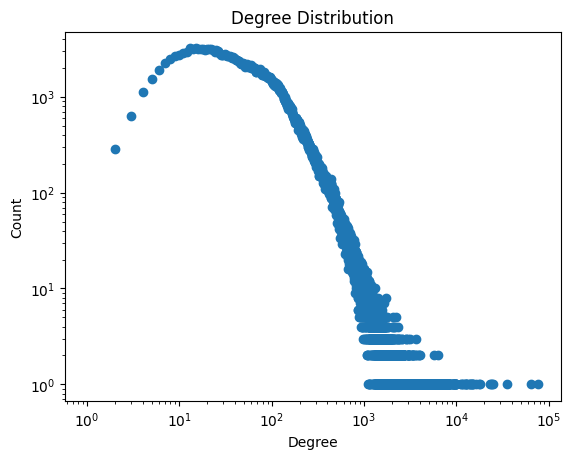

In [7]:
import numpy as np
# Get degree counts
hist = gt.vertex_hist(G_Wiki, "total")

# Plot on log-log scale
plt.loglog(hist[1][:-1], hist[0], 'o')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

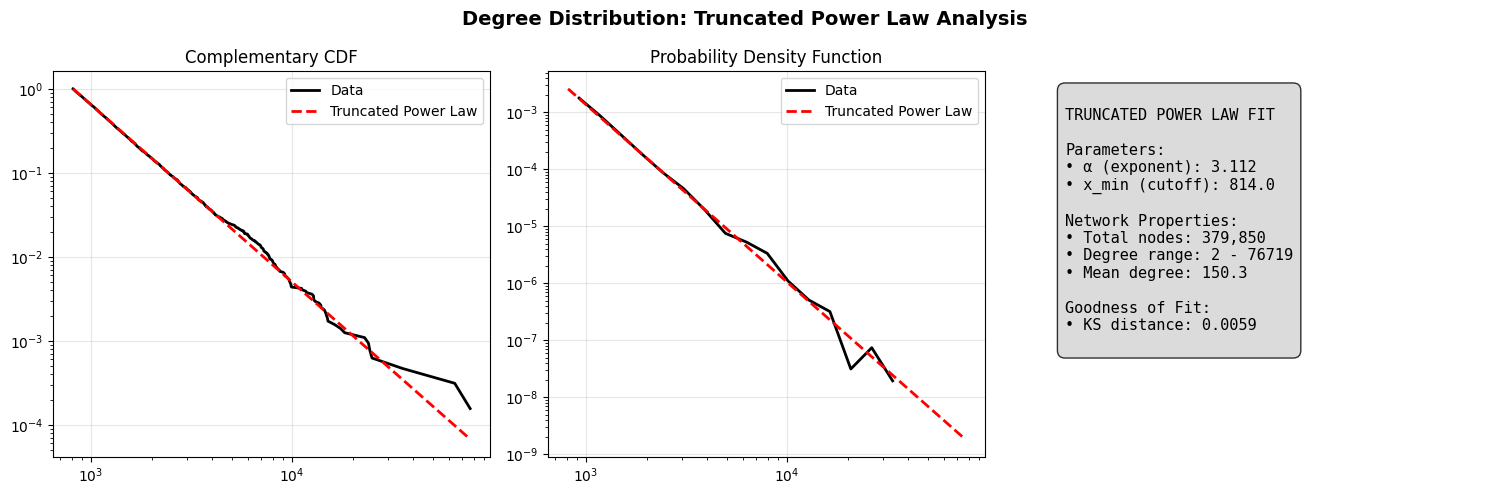

In [8]:
import powerlaw
import numpy as np
import matplotlib.pyplot as plt

# Get degree sequence
degrees = []
for v in G_Wiki.vertices():
    degrees.append(v.out_degree() + v.in_degree())
degrees = np.array(degrees)
degrees = degrees[degrees > 0]  # Remove zeros

# Fit truncated power law
fit = powerlaw.Fit(degrees, discrete=True, verbose=False)

# Create single comprehensive plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 1. CCDF with fit
fit.plot_ccdf(ax=ax1, color='black', linewidth=2, label='Data')
fit.power_law.plot_ccdf(ax=ax1, color='red', linestyle='--', 
                                  linewidth=2, label='Truncated Power Law')
ax1.set_title('Complementary CDF')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. PDF with fit  
fit.plot_pdf(ax=ax2, color='black', linewidth=2)
fit.power_law.plot_pdf(ax=ax2, color='red', linestyle='--', linewidth=2)
ax2.set_title('Probability Density Function')
ax2.legend(['Data', 'Truncated Power Law'])
ax2.grid(True, alpha=0.3)

# 3. Summary statistics
ax3.axis('off')
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
ks_distance = fit.power_law.D

summary_text = f"""
TRUNCATED POWER LAW FIT

Parameters:
• α (exponent): {alpha:.3f}
• x_min (cutoff): {xmin}

Network Properties:
• Total nodes: {len(degrees):,}
• Degree range: {degrees.min()} - {degrees.max()}
• Mean degree: {degrees.mean():.1f}

Goodness of Fit:
• KS distance: {ks_distance:.4f}
"""

ax3.text(0.05, 0.95, summary_text, transform=ax3.transAxes, 
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.suptitle('Degree Distribution: Truncated Power Law Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("/Users/ramius/Desktop/CodeVault/01_Project/Uni/DLSS_DeepLearningforSocialScientists/Final_Project/DLSS-WAQP/2_FinalReport/Images/Degree_PowerLaw.png", dpi=300, bbox_inches='tight')
plt.show()

***
## Network Features 

In [3]:
features = ['degree_in_centrality',
       'degree_out_centrality', 'pagerank', 'hub', 'authority', 'clustering',
       'core_numbers', 'reciprocity', 'betweenness', 'Target_QC_aggcat']

net_features = ['degree_in_centrality',
       'degree_out_centrality', 'pagerank', 'hub', 'authority', 'clustering',
       'core_numbers', 'reciprocity', 'betweenness']

categories = {
       "HQ" : 2,
       "MQ" : 1, 
       "LQ" : 0
}

rename_columns = {
       'degree_in_centrality' : "In-Degree",
       'degree_out_centrality' : "Out-Degree",
       'pagerank' : "Pagerank",
       'hub' : "Hub", 
       'authority' : "Authority", 
       'clustering' : "Clustering", 
       'core_numbers': "Coreness",
       'reciprocity': "Share-Reciprocal",
       'betweenness': "Betweenness"
}

In [4]:
df_full = pd.read_parquet("data/df_wiki_data.parquet")
df_netfeatures = df_full[features]

In [5]:
def create_ccdf_subplots(df, metrics_columns=None, figsize=(18, 10),
                        ncols=3, log_scale=False, save_path=None, group_col='Target_QC_aggcat',
                        category_mapping=None, rename_columns=None):
    """
    Create CCDF (Complementary Cumulative Distribution Function) plots as subplots
    with separate curves for each category in group_col
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the metrics
    metrics_columns : list, optional
        List of column names to plot. If None, uses all numeric columns
    figsize : tuple
        Figure size (width, height)
    ncols : int
        Number of columns in subplot grid
    log_scale : bool or list
        If True, use log scale for all plots. If list, specify per metric
    save_path : str, optional
        Path to save the figure
    group_col : str
        Column name for grouping (creates separate CCDF curves)
    category_mapping : dict, optional
        Dictionary to map category values to new names {old_value: new_value}
    rename_columns : dict, optional
        Dictionary to rename column names for display {old_name: new_name}
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    
    # Check if group column exists
    if group_col not in df.columns:
        raise ValueError(f"Group column '{group_col}' not found in dataframe")
    
    # Apply category mapping if provided
    df_plot = df.copy()
    if category_mapping is not None:
        # Create reverse mapping for display names (value -> key from your dict)
        reverse_mapping = {v: k for k, v in category_mapping.items()}
        df_plot[group_col] = df_plot[group_col].map(reverse_mapping).fillna(df_plot[group_col])
        print(f"Applied category mapping: {category_mapping}")
    
    # Apply column renaming if provided
    display_names = {}
    if rename_columns is not None:
        display_names = rename_columns.copy()
        print(f"Applied column renaming: {rename_columns}")
    
    # Select numeric columns if not specified
    if metrics_columns is None:
        metrics_columns = df_plot.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove any non-numeric or empty columns
    metrics_columns = [col for col in metrics_columns if col in df_plot.columns
                      and pd.api.types.is_numeric_dtype(df_plot[col])
                      and not df_plot[col].isna().all()]
    
    n_metrics = len(metrics_columns)
    if n_metrics == 0:
        raise ValueError("No valid numeric columns found in dataframe")
    
    # Get unique categories (excluding NaN) and sort them for consistent ordering
    categories = df_plot[group_col].dropna().unique()
    
    # Sort categories based on mapping order if provided
    if category_mapping is not None:
        # Sort by the original mapping order (HQ, MQ, LQ based on your values 2,1,0)
        category_order = sorted(category_mapping.keys(), key=lambda x: category_mapping[x], reverse=True)
        categories = [cat for cat in category_order if cat in categories]
        # Add any unmapped categories at the end
        categories.extend([cat for cat in df_plot[group_col].dropna().unique() if cat not in categories])
    
    n_categories = len(categories)
    
    print(f"Plotting {n_metrics} metrics for {n_categories} categories: {categories}")
    
    # Calculate subplot grid dimensions
    nrows = (n_metrics + ncols - 1) // ncols
    
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Handle single subplot case
    if n_metrics == 1:
        axes = [axes]
    elif nrows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    # Set up colors for different categories
    colors = plt.cm.Set1(np.linspace(0, 1, n_categories))
    
    # Create CCDF for each metric
    for i, metric in enumerate(metrics_columns):
        ax = axes[i]
        
        # Get display name for the metric
        display_name = display_names.get(metric, metric)
        
        # Plot CCDF for each category
        legend_elements = []
        
        for j, category in enumerate(categories):
            # Get data for this category
            category_data = df_plot[df_plot[group_col] == category][metric].dropna()
            
            if len(category_data) == 0:
                continue
            
            # Sort data for CCDF calculation
            sorted_data = np.sort(category_data)
            n = len(sorted_data)
            
            # Calculate CCDF (1 - CDF)
            ccdf_values = 1 - np.arange(1, n + 1) / n
            
            # Plot CCDF
            line = ax.plot(sorted_data, ccdf_values, linewidth=2, alpha=0.8,
                          color=colors[j], label=f'{category} (n={len(category_data)})')
            legend_elements.extend(line)
        
        # Check if any data was plotted
        if not legend_elements:
            ax.text(0.5, 0.5, f'No valid data\nfor {display_name}',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(display_name)
            continue
        
        # Set log scale if specified
        if isinstance(log_scale, bool) and log_scale:
            ax.set_yscale('log')
            ax.set_xscale('log')
        elif isinstance(log_scale, (list, tuple)) and i < len(log_scale):
            if log_scale[i]:
                ax.set_yscale('log')
                ax.set_xscale('log')
        
        # Customize plot
        ax.set_xlabel(display_name)
        ax.set_ylabel('P(X ≥ x)')
        ax.set_title(f'{display_name}')
        ax.grid(True, alpha=0.3)
        
        # Add legend
        ax.legend(loc='upper right', fontsize=8)
        
        # Add overall statistics as text (for all data combined)
        all_data = df_plot[metric].dropna()
        if len(all_data) > 0:
            stats_text = f'Overall:\nMean: {all_data.mean():.3f}\nStd: {all_data.std():.3f}\nN: {len(all_data)}'
            ax.text(0.5, 0.5, stats_text, transform=ax.transAxes,
                   verticalalignment='top', fontsize=8,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide empty subplots
    for i in range(n_metrics, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, axes

Applied category mapping: {'HQ': 2, 'MQ': 1, 'LQ': 0}
Applied column renaming: {'degree_in_centrality': 'In-Degree', 'degree_out_centrality': 'Out-Degree', 'pagerank': 'Pagerank', 'hub': 'Hub', 'authority': 'Authority', 'clustering': 'Clustering', 'core_numbers': 'Coreness', 'reciprocity': 'Share-Reciprocal', 'betweenness': 'Betweenness'}
Plotting 9 metrics for 3 categories: ['HQ', 'MQ', 'LQ']


(<Figure size 1800x1000 with 9 Axes>,
 array([<Axes: title={'center': 'In-Degree'}, xlabel='In-Degree', ylabel='P(X ≥ x)'>,
        <Axes: title={'center': 'Out-Degree'}, xlabel='Out-Degree', ylabel='P(X ≥ x)'>,
        <Axes: title={'center': 'Pagerank'}, xlabel='Pagerank', ylabel='P(X ≥ x)'>,
        <Axes: title={'center': 'Hub'}, xlabel='Hub', ylabel='P(X ≥ x)'>,
        <Axes: title={'center': 'Authority'}, xlabel='Authority', ylabel='P(X ≥ x)'>,
        <Axes: title={'center': 'Clustering'}, xlabel='Clustering', ylabel='P(X ≥ x)'>,
        <Axes: title={'center': 'Coreness'}, xlabel='Coreness', ylabel='P(X ≥ x)'>,
        <Axes: title={'center': 'Share-Reciprocal'}, xlabel='Share-Reciprocal', ylabel='P(X ≥ x)'>,
        <Axes: title={'center': 'Betweenness'}, xlabel='Betweenness', ylabel='P(X ≥ x)'>],
       dtype=object))

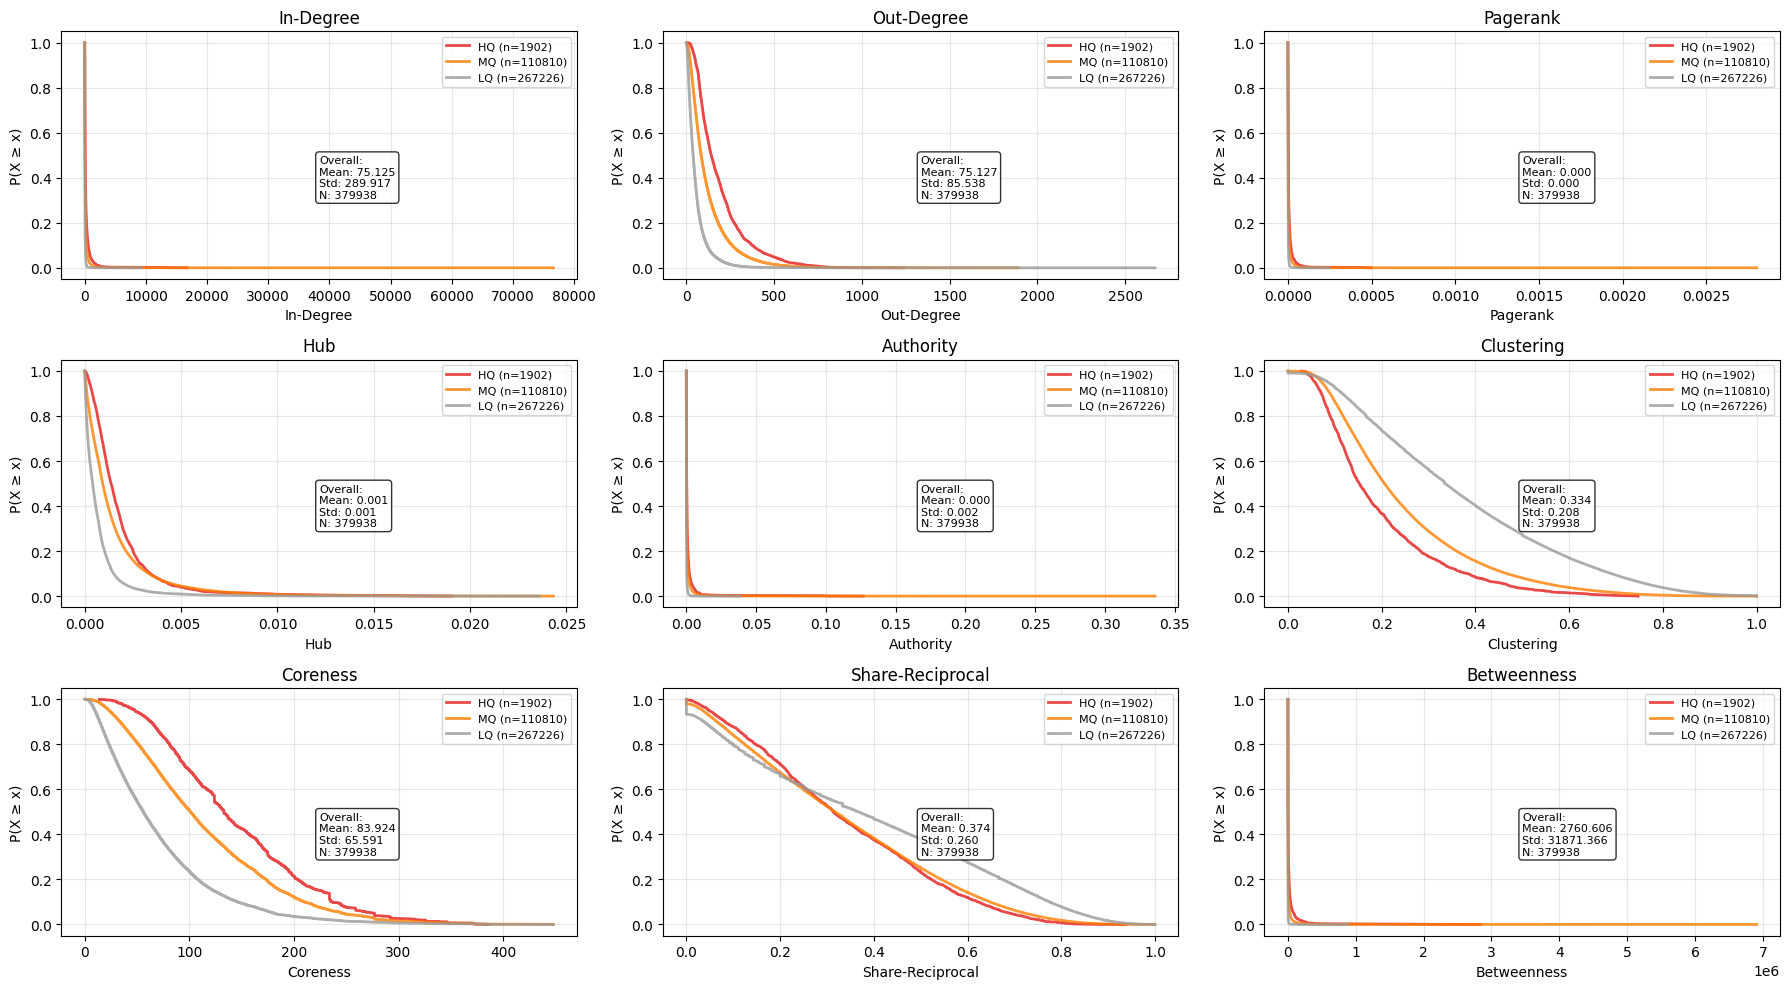

In [6]:
create_ccdf_subplots(df_netfeatures, 
                    metrics_columns=net_features, 
                    category_mapping=categories, 
                    rename_columns=rename_columns, 
                    save_path="/Users/ramius/Desktop/CodeVault/01_Project/Uni/DLSS_DeepLearningforSocialScientists/Final_Project/DLSS-WAQP/2_FinalReport/Images/netfeatures_category.png")

In [7]:
spectral = ['spectral_embedding_1',
       'spectral_embedding_2', 'spectral_embedding_3', 'spectral_embedding_4',
       'spectral_embedding_5', 'spectral_embedding_6', 'spectral_embedding_7',
       'spectral_embedding_8']

df_spectral = df_full[spectral]

#pick based on eigenvalue gaps

In [8]:
Eigenvalues = [3.83817920e-02, 4.12715390e-02, 5.38930876e-02,
 5.50006903e-02, 5.87030535e-0, 6.13357973e-02, 6.15405234e-02,
 7.18634899e-02]

In [9]:
def find_largest_gap_with_position(lst):
    if len(lst) < 2:
        return 0, -1
    
    gaps = [lst[i+1] - lst[i] for i in range(len(lst)-1)]
    max_gap = max(gaps)
    max_gap_index = gaps.index(max_gap)
    
    return max_gap, max_gap_index


gap_size, gap_position = find_largest_gap_with_position(Eigenvalues)
print(f"Between values {Eigenvalues[gap_position]} and {Eigenvalues[gap_position+1]}")

Between values 0.0550006903 and 5.87030535


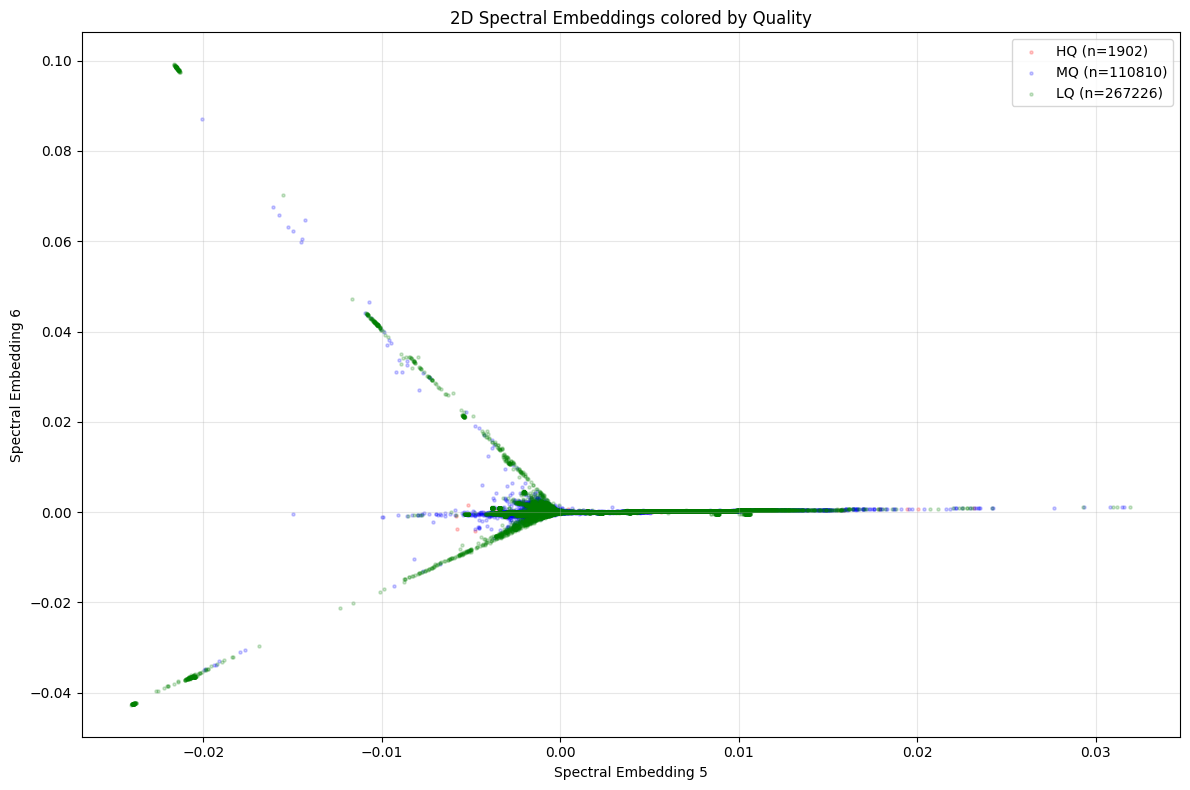

In [12]:
import matplotlib.pyplot as plt

# Apply your category mapping first
categories = {"HQ": 2, "MQ": 1, "LQ": 0}
reverse_mapping = {v: k for k, v in categories.items()}
df_full['Target_QC_mapped'] = df_full['Target_QC_aggcat'].map(reverse_mapping)

# Create 2D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# Define colors for each category
colors = {'HQ': 'red', 'MQ': 'blue', 'LQ': 'green'}

# Plot each category separately for better control
for category in ['HQ', 'MQ', 'LQ']:
    mask = df_full['Target_QC_mapped'] == category
    ax.scatter(df_full.loc[mask, "spectral_embedding_5"],
               df_full.loc[mask, "spectral_embedding_6"],
               label=f'{category} (n={mask.sum()})',
               alpha=0.2, s=5, c=colors[category])

ax.set_xlabel('Spectral Embedding 5')
ax.set_ylabel('Spectral Embedding 6') 
ax.set_title('2D Spectral Embeddings colored by Quality')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("/Users/ramius/Desktop/CodeVault/01_Project/Uni/DLSS_DeepLearningforSocialScientists/Final_Project/DLSS-WAQP/2_FinalReport/Images/2dspectral.png", dpi=300, bbox_inches='tight')
plt.show()